In [1]:
import keras
import os
import glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import random
from keras import backend as K
from keras.utils import np_utils
import tensorflow as tf

import imageio
from skimage import transform,io

import cv2
from sklearn.utils import shuffle

#from config import Config

Using TensorFlow backend.


In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [3]:
print(keras.__version__)

2.2.2


In [4]:
print(tf.__version__)

1.10.0


In [5]:
# function to plot history
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [6]:
# path to dataset
DATASET_PATH = 'color'

In [7]:
disease_cls = os.listdir(DATASET_PATH)
print('List of Classes: ', disease_cls)
print('Number of Classes: ', len(disease_cls))

List of Classes:  ['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Target_Spot', 'Soybean___healthy', 'Raspberry___healthy', 'Corn_(maize)___Common_rust_', 'Tomato___Tomato_mosaic_virus', 'Squash___Powdery_mildew', 'Potato___Early_blight', 'Apple___Apple_scab', 'Strawberry___healthy', 'Potato___healthy', 'Grape___Esca_(Black_Measles)', 'Cherry_(including_sour)___Powdery_mildew', 'Potato___Late_blight', 'Tomato___Early_blight', 'Cherry_(including_sour)___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___healthy', 'Blueberry___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Pepper,_bell___Bacterial_spot', 'Apple___Black_rot', 'Strawberry___Leaf_scorch', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Peach___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Leaf_Mold', 'Tomato___Late_blight', 'Peach___healthy', 'Tomato___Bacterial_spot', 'Grape__

In [8]:
#generating dataframes of images and labels
labels = [x for x in range(len(disease_cls))]
images = []
labels_cls = []
name_cls = []
for i in labels:
    #temp_im_list = []
    temp_path = DATASET_PATH + '/' + disease_cls[i]
    im_list = os.listdir(temp_path)
    for j in im_list:
        temp_path1 = temp_path + '/' + j
        images.append(temp_path1)
        labels_cls.append(i)
        name_cls.append(disease_cls[i])
data = pd.DataFrame()
data['FileName']= images
data['Label']= labels_cls
data['ClassName'] = name_cls
data.shape

(54305, 3)

In [9]:
from sklearn.model_selection import train_test_split
# Split the data
train, val= train_test_split(data, test_size=0.2, shuffle= True, random_state = 100)

In [10]:
def load_samples(data):
    file_names = list(data.iloc[:,0])
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

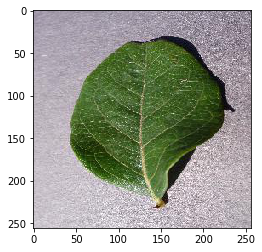

In [11]:
#randomly chosen images
import random
rand_index = random.randint(0, len(images))
image = io.imread(images[rand_index])
plt.imshow(image)

In [12]:
print(image.shape)

(256, 256, 3)


### Generator

In [13]:
num_classes = 38
resize=150
def data_generator(samples, batch_size=32,shuffle_data=True,resize=resize):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                #img =  cv2.imread(os.path.join(root_dir,img_name))
                img =  cv2.imread(img_name)
                img = cv2.resize(img,(resize,resize))
                img = img/255
                label = np_utils.to_categorical(label, num_classes)
                
                # apply any kind of preprocessing
                #img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [14]:
train_samples = load_samples(train)
val_samples = load_samples(val)

num_train_samples = len(train_samples)
num_val_samples = len(val_samples)

print ('number of train samples: ', num_train_samples)
print ('number of val samples: ', num_val_samples)

number of train samples:  43444
number of val samples:  10861


In [15]:
# Create generator
batch_size=1000
train_generator = data_generator(train_samples, batch_size=batch_size)
validation_generator = data_generator(val_samples, batch_size=batch_size)

#### Model Building

In [16]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(resize, resize, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['categorical_accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [17]:
history = model.fit_generator(generator=train_generator, validation_data=validation_generator, 
                               epochs=30, steps_per_epoch= num_train_samples // batch_size,
                              validation_steps=num_val_samples // batch_size)

Epoch 1/30
43/43 [==============================] - 355s 8s/step - loss: 3.1072 - categorical_accuracy: 0.1871 - val_loss: 2.3563 - val_categorical_accuracy: 0.3630
Epoch 2/30
43/43 [==============================] - 106s 2s/step - loss: 1.8600 - categorical_accuracy: 0.4761 - val_loss: 1.2336 - val_categorical_accuracy: 0.6459
Epoch 3/30
43/43 [==============================] - 98s 2s/step - loss: 1.1848 - categorical_accuracy: 0.6461 - val_loss: 0.7880 - val_categorical_accuracy: 0.7615
Epoch 4/30
43/43 [==============================] - 101s 2s/step - loss: 0.8636 - categorical_accuracy: 0.7328 - val_loss: 0.6337 - val_categorical_accuracy: 0.8048
Epoch 5/30
43/43 [==============================] - 100s 2s/step - loss: 0.6945 - categorical_accuracy: 0.7821 - val_loss: 0.5317 - val_categorical_accuracy: 0.8279
Epoch 6/30
43/43 [==============================] - 100s 2s/step - loss: 0.5891 - categorical_accuracy: 0.8139 - val_loss: 0.4034 - val_categorical_accuracy: 0.8709
Epoch 7/30


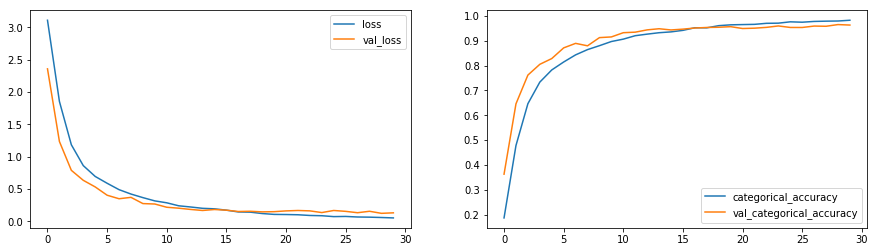

In [18]:
plot(history)